## The effect of mixing geometry on evolution

This notebook examines the effect of mixing geometry on evolutionary rate. We consider a hypercube sea of individuals, where each axis mixes at a different rate. Is it better for all axes to mix at the same rate (i.e. all slowly or all rapidly), or is it better for some axes to mix at different rates than other axes?

In [14]:
import math
from types import SimpleNamespace
import matplotlib.pyplot as plt
import tqdm
import torch

In [2]:
def migrate(args, pangenome: torch.Tensor) -> torch.Tensor:
    """
    Creates a similarly shaped pangenome with each cell replaced by a nearby cell.
    """
    # Create a gradation of mixing along dimensions of a hypercube.
    assert 0 < args.min_migration_rate <= args.max_migration_rate < 1
    per_dim_rate = torch.linspace(
        math.log(args.min_migration_rate),
        math.log(args.max_migration_rate),
        args.dimension,
    ).exp()

    # Randomly migrate along each dimension.
    N = len(pangenome)
    index = torch.arange(N)
    for i, rate in enumerate(per_dim_rate):
        index ^= (torch.rand(N) < rate).long() << i
    return pangenome[index]

In [3]:
def mutate(args, pangenome: torch.Tensor) -> None:
    """
    Randomly flips bits in-place.
    """
    N = len(pangenome)
    for i in range(64):
        pangenome ^= (torch.rand(N) < args.mutation_rate).long() << i

In [4]:
def crossover(child: torch.tensor, parent: torch.tensor):
    assert child.shape == parent.shape
    mask = (-2 ** 63) >> torch.randint(64, child.shape)
    mask = torch.where(torch.empty(child.shape).bernoulli_().bool(), mask, ~mask)
    child &= ~mask
    child |= mask & parent

In [76]:
gene_sizes = [4, 5, 6, 7, 8, 4, 5, 6, 7, 8, 4]
gene_sizes = [6, 7, 7, 8, 8, 9, 9, 10]
assert sum(gene_sizes) == 64, sum(gene_sizes)
genes = []
begin = 0
for gene_size in gene_sizes:
    gene = (2 ** gene_size - 1) << begin
    if gene >= 2 ** 63:
        gene -= 2 ** 64
    genes.append(gene)
    begin += gene_size
genes = torch.tensor(genes)
print(f"Created {len(genes)} genes")

Created 8 genes


In [77]:
def get_fitness(genome: torch.Tensor):
    masked = genome[..., None] & genes
    return masked.eq(0).float().sum(-1) + 2 * masked.eq(genes).float().sum(-1)

In [78]:
def init(args) -> dict:
    pangenome = torch.zeros(2 ** args.dimension, dtype=torch.long)
    fitness = get_fitness(pangenome)
    return {"pangenome": pangenome, "fitness": fitness}

In [79]:
def step(args, state: dict) -> None:
    pangenome = migrate(args, state["pangenome"])
    mutate(args, pangenome)
    crossover(pangenome, state["pangenome"])
    fitness = get_fitness(pangenome)
    probs = (fitness - state["fitness"]).sigmoid()
    selected = torch.bernoulli(probs).bool()
    state["pangenome"] = torch.where(selected, pangenome, state["pangenome"])
    state["fitness"] = torch.where(selected, fitness, state["fitness"])

In [86]:
def solve(args):
    torch.manual_seed(hash(args))
    state = init(args)
    best = [state["fitness"].max().item()]
    mean = [state["fitness"].mean().item()]
    for t in tqdm.tqdm(range(args.num_steps)):
        step(args, state)
        best.append(state["fitness"].max().item())
        mean.append(state["fitness"].mean().item())
    return {
        "best": torch.tensor(best),
        "mean": torch.tensor(mean),
        "final": state["fitness"],
        "final_best": state["fitness"].max().item(),
        "final_mean": state["fitness"].mean().item(),
    }

In [87]:
class Args(SimpleNamespace):
    def __hash__(self):
        return hash(frozenset(self.__dict__.items()))
    def copy(self):
        return Args(**self.__dict__)

In [88]:
default_args = Args(
    dimension=14,
    min_migration_rate=0.001,
    max_migration_rate=0.05,
    mutation_rate=1 / 64,
    num_steps=1000,
)
solution = solve(default_args)
print(solution["final_best"])

100%|██████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.95it/s]

16.0


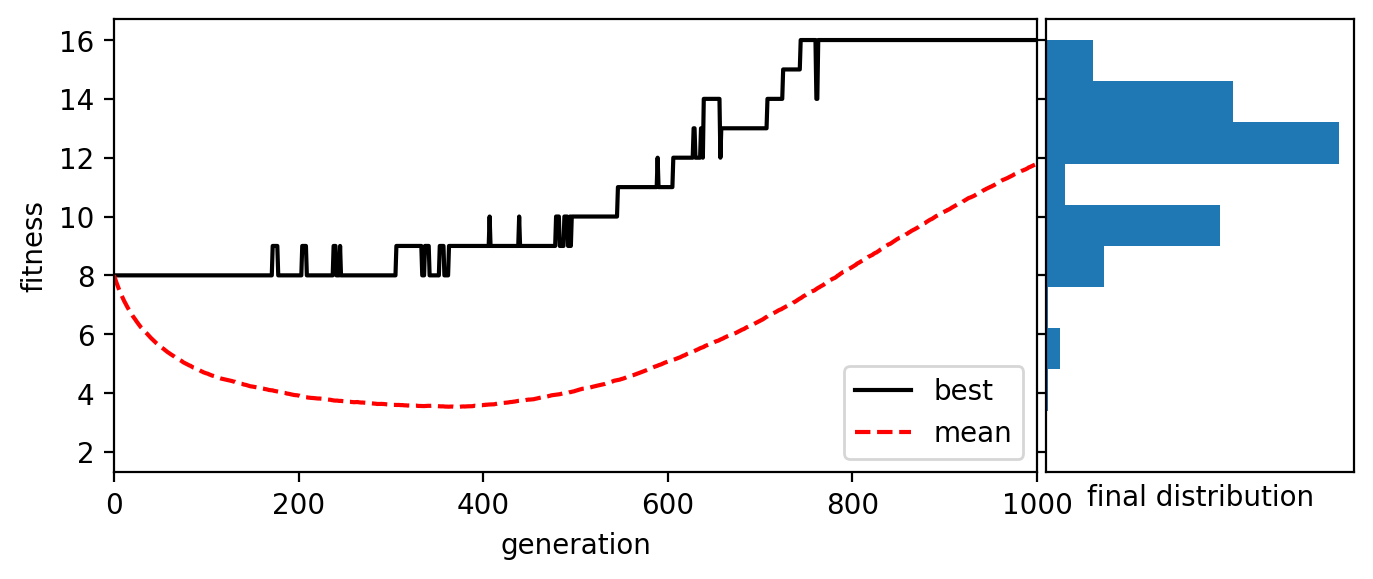

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True,
                         gridspec_kw={"width_ratios": [3, 1]}, dpi=200)
fig.patch.set_color("white")
axes[0].plot(solution["best"], "k-", label="best")
axes[0].plot(solution["mean"], "r--", label="mean")
axes[0].set_ylabel("fitness")
axes[0].set_xlabel("generation")
axes[0].set_xlim(0, len(solution["best"]) - 1)
axes[0].legend(loc="lower right")
axes[1].hist(solution["final"].numpy(), orientation="horizontal")
axes[1].set_xlabel("final distribution")
axes[1].set_xticks(())
plt.subplots_adjust(wspace=0.015)

## Exploring the landscape of geometries

Now consider the 2-dimensional space parameterized by `(min_migration_rate, max_migration_rate)`.

In [91]:
solution_cache = {}

In [103]:
#odds = torch.linspace(math.log(0.001), 0.0, 5 + 1).exp()
#odds = torch.linspace(math.log(0.001), 0.0, 10 + 1).exp()
odds = torch.linspace(math.log(0.001), 0.0, 20 + 1).exp()
print(odds)

tensor([1.0000e-03, 1.4125e-03, 1.9953e-03, 2.8184e-03, 3.9811e-03, 5.6234e-03,
        7.9433e-03, 1.1220e-02, 1.5849e-02, 2.2387e-02, 3.1623e-02, 4.4668e-02,
        6.3096e-02, 8.9125e-02, 1.2589e-01, 1.7783e-01, 2.5119e-01, 3.5481e-01,
        5.0119e-01, 7.0795e-01, 1.0000e+00])


In [104]:
rates = odds / (1 + odds)
# Quantize so linspace grids can be cheaply refined.
rates = [int(rate * 8192) / 8192 for rate in rates.tolist()]
print(rates)

[0.0009765625, 0.0013427734375, 0.001953125, 0.0028076171875, 0.00390625, 0.0054931640625, 0.0078125, 0.010986328125, 0.0155029296875, 0.0218505859375, 0.0306396484375, 0.042724609375, 0.059326171875, 0.081787109375, 0.1116943359375, 0.15087890625, 0.20068359375, 0.2618408203125, 0.333740234375, 0.4144287109375, 0.5]


In [107]:
for min_rate in rates:
    for max_rate in rates:
        if min_rate > max_rate:
            continue
        args = default_args.copy()
        args.min_migration_rate = min_rate
        args.max_migration_rate = max_rate
        if args in solution_cache:
            continue
        solution_cache[args] = solve(args)

100%|██████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.87it/s]


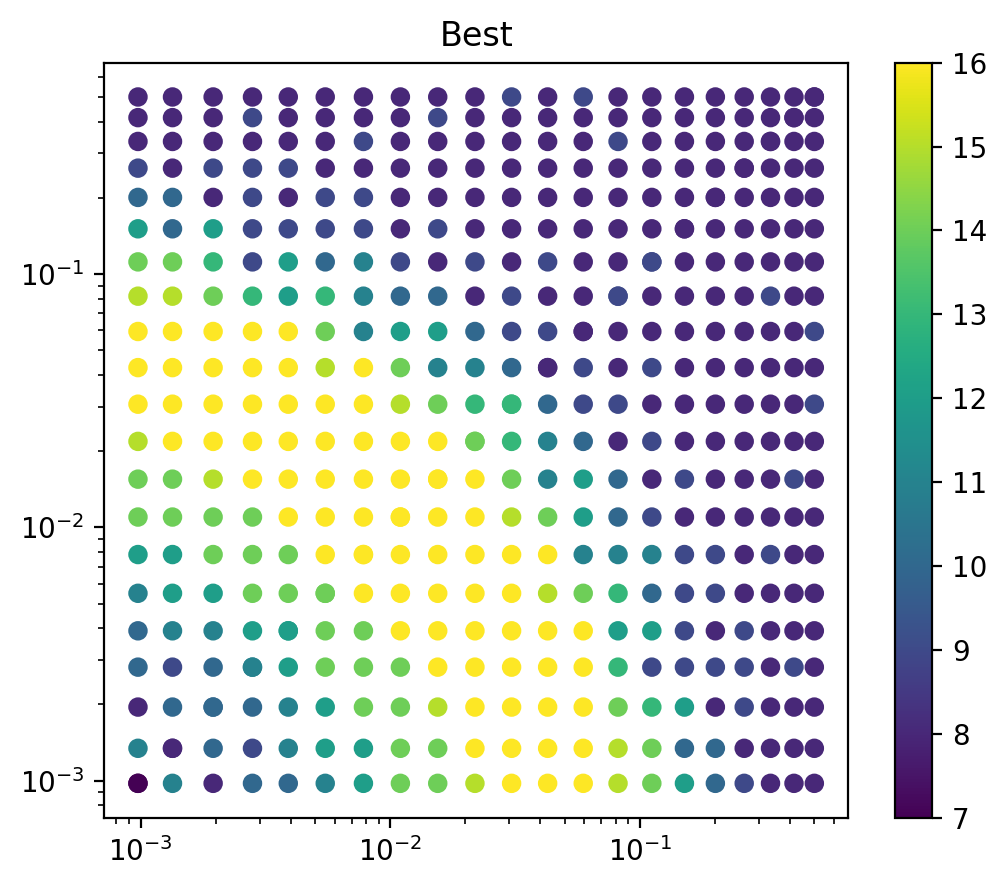

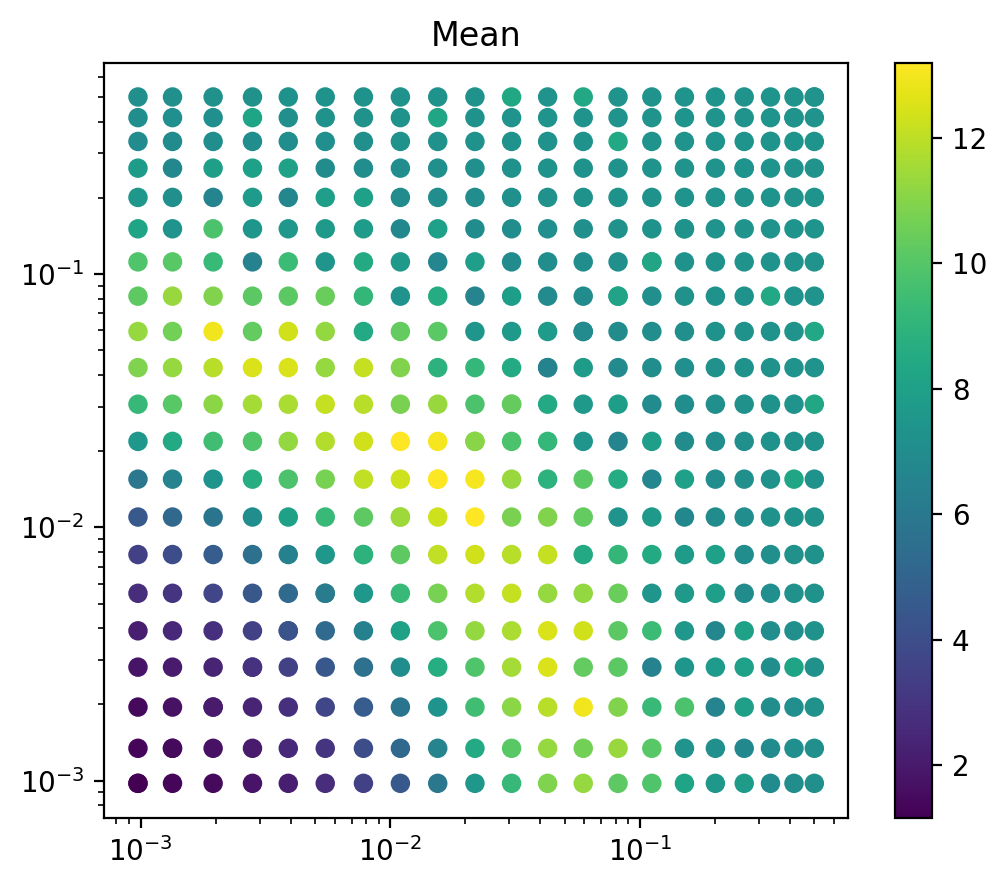

In [108]:
def plot_landscape(kind="best"):
    X, Y, C = [], [], []
    for args, solution in solution_cache.items():
        X.extend([args.min_migration_rate, args.max_migration_rate])
        Y.extend([args.max_migration_rate, args.min_migration_rate])
        C.extend([solution[f"final_{kind}"], solution[f"final_{kind}"]])
    plt.figure(figsize=(6, 5), dpi=200).patch.set_color("white")
    plt.scatter(X, Y, c=C)
    plt.xscale("log")
    plt.yscale("log")
    plt.colorbar()
    plt.title(kind.capitalize())

plot_landscape("best")
plot_landscape("mean")